In [1]:
import pandas as pd
import torch
from torch.utils import data
import numpy as np
from PIL import Image
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torchvision 
import torchvision.transforms.functional as func
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

In [3]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)

In [4]:
class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
    
        self.root = root
        # the type is numpy.ndarray
        self.img_name, self.label = getData(mode)
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, index):

        # Step 1.Get the image path from 'self.img_name' and load it
        path = self.root + self.img_name[index] + '.jpeg' 
        img  = Image.open(path).convert('RGB')
        
        # Step 2.Get the ground truth label
        label = self.label[index]
        
        transform = transforms.Compose([
#         transforms.ToPILImage(),
        transforms.ToTensor()])
#         transforms.RandomCrop((300,300))])
        
        # Step 3.Transform the .jpeg rgb images
        img = transform(img)
        img = torch.unsqueeze(img, 0)
        label = torch.from_numpy(np.array(label))
#         img = transforms.Normalize(img,(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         img = torchvision.transforms.ToPILImage(img)
#         img = torchvision.transforms.ToTensor()(img)

        return img, label

In [5]:
reti_loader = RetinopathyLoader("/home/wang/Desktop/Auberon/LAB3/data/", "train")

> Found 28099 images...


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
#         self.bn1 = nn.BatchNorm2d(64)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        # maxpool 處理
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.linear = nn.Linear(512*block.expansion, num_classes)
        self.linear = nn.Linear(in_features=51200, out_features=1000, bias=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # maxpool處理
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         out = F.avg_pool2d(out, 4)
        out = F.avg_pool2d(out, kernel_size=7, stride=1, padding=0)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# ResNet架構來源 https://zhuanlan.zhihu.com/p/31852747
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


def test():
    net = ResNet18()
#     y = net(torch.randn(1,3,32,32))
    y = net(reti_loader[0][0])
    print(y.size())
    print(y)

# test()

In [69]:
# 呼叫ResNet18
net = ResNet18()
# GPU運算
net.to(device)
# loss function
loss_fun = F.cross_entropy
# optimizer 
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)
# 起始running_loss
running_loss = 0.0

# 計算ACC
true_ans = 0.0
false_ans = 0.0

# Number of train data
# num_train = 28099
num_train = 1000

In [70]:
def ResNet18_train(n):
    running_loss = 0.0
    true_ans = 0.0
    false_ans = 0.0
    confusion_yTrue = []
    confusion_yPred = []
    
    for i in range(n):
        inputs = reti_loader[i][0].to(device)
        labels = reti_loader[i][1].to(device)
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        labels = torch.unsqueeze(labels, 0)
        output = loss_fun(outputs, labels)
        output.backward()
        output

        optimizer.step()

        running_loss =+ output.cpu().data.numpy()
        net.eval()

        result = output

        ground_true = labels.cpu().detach().numpy()[0]
        pred_y = np.round(result.cpu().detach().numpy())
        confusion_yTrue.append(ground_true)
        confusion_yPred.append(pred_y)
        
        if ground_true == pred_y:
            true_ans = true_ans + 1
        else:
            false_ans = false_ans + 1
    return true_ans, false_ans, confusion_yTrue, confusion_yPred
    

In [71]:
# 運算
epoch_list = []
acc_list = []

for epoch in range(10):
    epoch_list.append(epoch)
    print ("This is epoch "+ str(epoch+1))
    
    result = ResNet18_train(num_train)
    y_test = result[2]
    y_pred = result[3]
    ACC = (result[0]/(result[0]+result[1]))
    
    acc_list.append(ACC)
    print ("The ACC is : "+str(ACC))

This is epoch 1
The ACC is : 0.618
This is epoch 2
The ACC is : 0.665
This is epoch 3
The ACC is : 0.698
This is epoch 4
The ACC is : 0.719
This is epoch 5
The ACC is : 0.729
This is epoch 6
The ACC is : 0.74
This is epoch 7
The ACC is : 0.755
This is epoch 8
The ACC is : 0.765
This is epoch 9
The ACC is : 0.771
This is epoch 10
The ACC is : 0.781


In [45]:
# y_test = np.array(y_test).astype(int)

In [47]:
# y_pred = np.array(y_pred).astype(int)

In [72]:
y_actu = y_test
y_pred = y_pred
df_confusion = confusion_matrix(y_actu, y_pred)

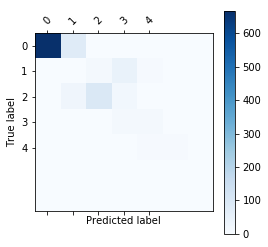

In [82]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, classes = ['0','1','2','3','4'],title=None, normalize=False,cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

plot_confusion_matrix(df_confusion)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
